# Applied Bayesian Data Analysis - Homework 4
| Name        | Id         |
| -------------|:----------:|
| Noam Siegel    | 314475062 |

### Imports

In [33]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
from torch.distributions import constraints
from tqdm import tqdm

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.contrib.autoguide import AutoDelta, AutoNormal
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, MCMC, NUTS, predictive, infer_discrete
from pyro.infer import Predictive

pyro.enable_validation(True)
pyro.set_rng_seed(0)

# Problem 1: Unsupervised Exploration of Iris Dataset

The Iris dataset includes the sepal and petal length and width, for three species of irides: setosa, versicolor, virginica. 

How well do the features separate species?

## The data
We download the data from the course's website.

We observe:

todo: update using other GH branch

1. We see that the data is exactly balanced (50 samples per species).
2. The setosa is very different from the versicolor/virginica in terms of petal length/width.
3. The petal lengths and petal widths are, expectedly, highly correlated.

In [3]:
# url = 'https://bgu-abda.bitbucket.io/homework/04iris.csv'
url = '../input/04iris.csv'
df = pd.read_csv(url)
df = df.rename({'sepal length (cm)' : 'sepal_length', 'sepal width (cm)' : 'sepal_width',
                'petal length (cm)' : 'petal_length', 'petal width (cm)' : 'petal_width'}, axis='columns')
df["label"] = df['species'].astype('category').cat.codes
features = ["sepal_length", "sepal_width", "petal_length", "petal_width"]

def preprocess_data(df):
    # select features, normalize, PCA
    X = df[features].values
    sclr = StandardScaler()
    X = sclr.fit_transform(X)
    pca = PCA()
    X = pca.fit_transform(X)
    return torch.tensor(X).float()

X = preprocess_data(df)
assert torch.is_tensor(X) and X.shape == (len(df), len(features)) 

df.sample(8)

,sepal_length,sepal_width,petal_length,petal_width,species,label
114,5.8,2.8,5.1,2.4,virginica,2
62,6.0,2.2,4.0,1.0,versicolor,1
33,5.5,4.2,1.4,0.2,setosa,0
107,7.3,2.9,6.3,1.8,virginica,2
7,5.0,3.4,1.5,0.2,setosa,0
100,6.3,3.3,6.0,2.5,virginica,2
40,5.0,3.5,1.3,0.3,setosa,0
86,6.7,3.1,4.7,1.5,versicolor,1


Visual inspection of the reduced-dimensionality dataset tells us that the setosa is very distinguishable from the versicolor/virginica, but the versicolor and virginica have some unseperable overlap.

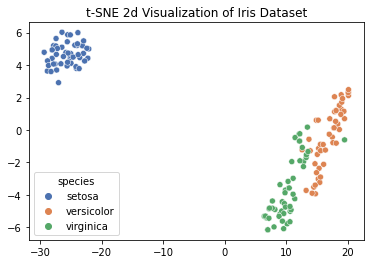

In [4]:
def visualize_data_tsne(df):
    tsne = TSNE(n_components=2, init='pca')
    X_embedded = tsne.fit_transform(df[features].values)
    sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=df.species, palette="deep").set(title="t-SNE 2d Visualization of Iris Dataset");
visualize_data_tsne(df)

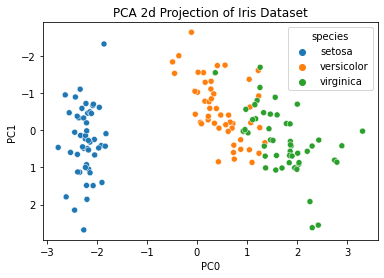

In [5]:
def visualize_data_pca(X):
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=df.species).set(title="PCA 2d Projection of Iris Dataset", xlabel="PC0", ylabel="PC1");
visualize_data_pca(X)

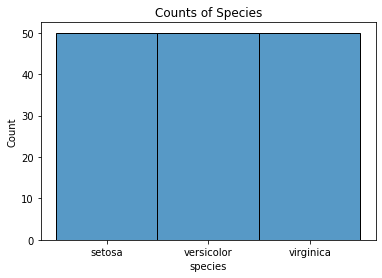

In [6]:
sns.histplot(data=df.species).set(title="Counts of Species");

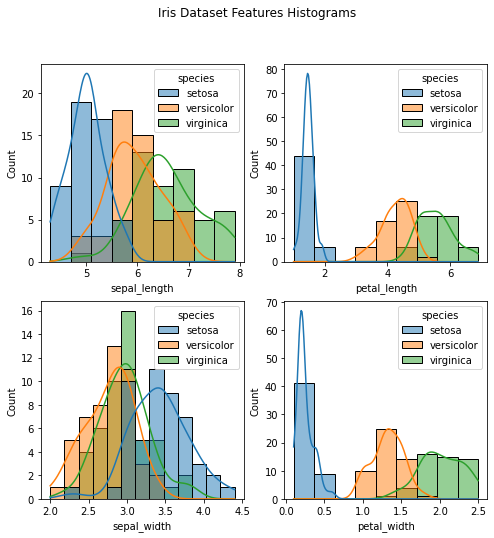

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
fig.suptitle('Iris Dataset Features Histograms')
kde = True
sns.histplot(ax=axes[0,0], data=df, x='sepal_length', kde=kde, hue="species")
sns.histplot(ax=axes[1,0], data=df, x='sepal_width', kde=kde, hue="species")
sns.histplot(ax=axes[0,1], data=df, x='petal_length', kde=kde, hue="species")
sns.histplot(ax=axes[1,1], data=df, x='petal_width', kde=kde, hue="species");

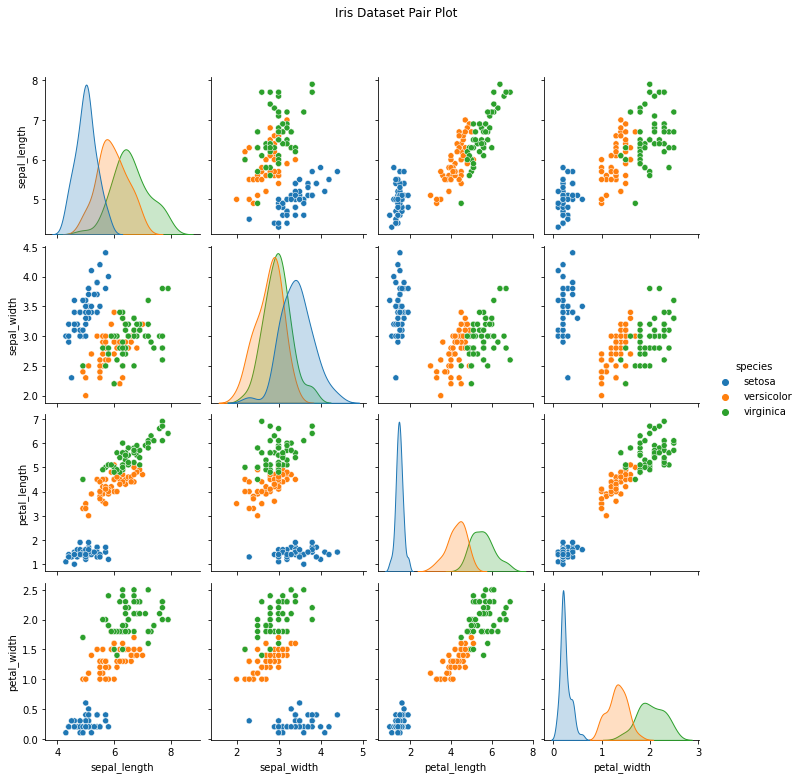

In [8]:
g = sns.pairplot(df.drop(["label"], axis=1), hue="species")
g.fig.suptitle("Iris Dataset Pair Plot", y=1.08);

## Defining the Models
We will define two models:

1. A Gaussian mixture model with 3 components and shared scalings.
2. A Gaussian mixture model with 3 components and separate scalings.

In [9]:
K = 3

In [10]:
def is_pos_def(x):
    x = x.numpy()
    return np.all(np.linalg.eigvals(x) > 0)

In [79]:
@config_enumerate
def model_shared_scale(data):
    # todo: add constraints on components order
    # K is number of mixture components
    # D is dimension of each data point
    assert type(K) == int  # define K in global environment
    D = data.size(-1)

    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(torch.zeros(D), 10 * torch.ones(D)).to_event(1))
    # print(f"weights shape is {weights.shape}")
    # print(f"scale shape is {scale.shape}")
    # print(f"locs shape is {locs.shape}")
    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        # print(f"assignment shape is {assignment.shape}")
        # print(f"locs[assignment] shape is {locs[assignment].shape}")
        # print(f"scale * torch.eye(D) shape is {scale * torch.eye(D)}")
        pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scale * torch.eye(D)), obs=data)

In [108]:
@config_enumerate
def model_diag_scales(data):
    # todo: add constraints on components order
    # K is number of mixture components
    # D is dimension of each data point
    assert type(K) == int  # define K in global environment
    D = data.size(-1)

    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(torch.zeros(D), 10 * torch.ones(D)).to_event(1))
        scales = pyro.sample('scales', dist.LogNormal(0., 2.))
    
    # print(f"weights shape is {weights.shape}")
    print(f"scales shape is {scales.shape}")
    # print(f"locs shape is {locs.shape}")
    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        # print(f"assignment shape is {assignment.shape}")
        print(f"scales[assignment] shape is {scales[assignment].shape}")
        print(f"scales[assignment] * torch.eye(D) shape is {scales[assignment] * torch.eye(D).expand((len(data), D, D))}")
        print(f"locs[assignment] shape is {locs[assignment].shape}")
        pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scales[assignment] * torch.eye(D).expand((len(data), D, D))), obs=data)

In [12]:
@config_enumerate
def model_separate_scales(data):
    # K is number of mixture components
    # D is dimension of each data point
    assert type(K) == int  # define K in global environment
    D = data.size(-1)

    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    # scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(torch.zeros(D), 10 * torch.ones(D)).to_event(1))
        # v = pyro.sample('vector_1', dist.Normal(torch.zeros(D), 10 * torch.ones(D)).to_event(1))
        # v2 = pyro.sample('vector_2', dist.Normal(torch.zeros(D), 10 * torch.ones(D)).to_event(1))
        M = pyro.sample('matrix', dist.Normal(torch.zeros((D, D)), 1 * torch.ones((D, D))).to_event(2))
        # print(f"shape of v before {v.shape}")
        # v = v.unsqueeze(-2)
        # v_transposed = torch.transpose(v, -1, -2)
        # print(f"v is {v}")
        # print(f"v2 is {v2}")
        # print(f"shape of v after {v.shape}")
        # print(f"shape of v2 after {v2.shape}")
        # print(f"shape of v_transposed after {v_transposed.shape}")
        # scales = torch.matmul(v_transposed, v)
        # scales = torch.bmm(v_transposed, v)
        # scales = torch.einsum('bp, bq -> bpq', v, v)
        M_transposed = torch.transpose(M, -1, -2)
        # print(f"M is {M}")
        # print(f"M_transposed is {M_transposed}")
        scales = torch.bmm(M, M_transposed)
        # print(f"shape of scales after {scales.shape}")
        # print(f"scales is {scales}")
        # for i in range(K):
            # print(f"the ith scale is {scales[i]}")
            # assert is_pos_def(scales[i]), f"i is {i}, eigvals are {np.linalg.eigvals(scales[i].detach().numpy())}"

    # print(f"weights shape is {weights.shape}")
    # print(f"scale shape is {scale.shape}")
    # print(f"locs shape is {locs.shape}")
    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        # print(f"assignment shape is {assignment.shape}")
        # print(f"locs[assignment] shape is {locs[assignment].shape}")
        # print(f"scales[assignment] shape is {scales[assignment].shape}")
        # print(f"scales is {scales}")
        # print(f"locs[assignment] is {locs[assignment]}")
        # print(f"scales[assignment] is {scales[assignment]}")
        # print(f"scale * torch.eye(D) shape is {scale * torch.eye(D)}")
        obs = pyro.sample('obs', dist.MultivariateNormal(locs[assignment], scales[assignment]), obs=data)
        # print(f"obs shape is {obs.shape}")
        # print(f"obs is {obs}")

## Sampling the Models
We use the NUTS sampler to retrieve chains for each of the three models. We report summary statistics for each of the parameters for each model.


In [67]:
def get_mcmc(model, args, num_samples=16):
    # todo: raise the num_samples to 1500
    """Wrapper for mcmc.run() with NUTS kernel"""
    nuts_kernel = NUTS(model)
    mcmc = MCMC(nuts_kernel, num_samples=num_samples)
    mcmc.run(*args)
    return mcmc

In [89]:
sample_shared = lambda X: get_mcmc(model_shared_scale, (X,))
sample_diag = lambda X: get_mcmc(model_diag_scales, (X,))
sample_separate = lambda X: get_mcmc(model_separate_scales, (X,))

In [15]:
mcmc_shared = sample_shared(X)
chn_shared = mcmc_shared.get_samples()
mcmc_shared.summary()

Sample: 100%|██████████| 800/800 [00:29, 26.73it/s, step size=6.13e-01, acc. prob=0.870]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
 locs[0,0]     -2.23      0.07     -2.23     -2.34     -2.10    691.05      1.00
 locs[0,1]      0.30      0.08      0.30      0.16      0.41   1408.79      1.00
 locs[0,2]     -0.05      0.07     -0.04     -0.16      0.08    953.70      1.00
 locs[0,3]     -0.02      0.07     -0.02     -0.13      0.10   1119.90      1.00
 locs[1,0]      0.59      0.08      0.59      0.45      0.71    382.09      1.00
 locs[1,1]     -0.78      0.10     -0.78     -0.94     -0.60    348.37      1.00
 locs[1,2]      0.04      0.07      0.04     -0.06      0.16    833.84      1.00
 locs[1,3]      0.03      0.07      0.03     -0.09      0.13   1538.69      1.00
 locs[2,0]      1.72      0.10      1.72      1.55      1.89    468.96      1.00
 locs[2,1]      0.60      0.10      0.60      0.43      0.74    468.59      1.00
 locs[2,2]      0.00      0.08      0.00     -0.12      0.13   1601.81      1.00
 locs[2,3]     -0.02      0

In [109]:
mcmc_diag = sample_diag(X)
chn_diag = mcmc_diag.get_samples()
mcmc_diag.summary()

Warmup:   0%|          | 0/32 [00:00, ?it/s]

scales shape is torch.Size([3])
scales[assignment] shape is torch.Size([150])
identity is torch.Size([4, 4])


RuntimeError: The size of tensor a (150) must match the size of tensor b (4) at non-singleton dimension 2
  Trace Shapes:        
   Param Sites:        
            eye   4 4  
  Sample Sites:        
   weights dist     | 3
          value     | 3
components dist     |  
          value   3 |  
      locs dist   3 | 4
          value   3 | 4
    scales dist   3 |  
          value   3 |  
      data dist     |  
          value 150 |  
assignment dist 150 |  
          value 150 |  

In [16]:
mcmc_separate = sample_separate(X)
chn_separate = mcmc_separate.get_samples()
mcmc_separate.summary()

Sample: 100%|██████████| 800/800 [09:23,  1.42it/s, step size=7.51e-02, acc. prob=0.894]


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
    locs[0,0]     -0.01      0.18     -0.01     -0.31      0.27   1436.92      1.00
    locs[0,1]      0.01      0.08      0.01     -0.12      0.15    662.99      1.00
    locs[0,2]      0.00      0.03      0.00     -0.04      0.05    632.07      1.00
    locs[0,3]     -0.00      0.01     -0.00     -0.02      0.02   1029.97      1.00
    locs[1,0]      0.01      9.59     -0.09    -16.01     13.99    773.00      1.01
    locs[1,1]      0.32     10.60      0.54    -16.84     17.87   1796.38      1.00
    locs[1,2]     -0.27     10.34     -0.48    -17.67     15.90   1143.46      1.00
    locs[1,3]      0.20      9.44      0.54    -15.17     16.28    659.57      1.00
    locs[2,0]      0.47      9.70      0.11    -13.77     18.74    749.94      1.01
    locs[2,1]     -0.33     10.17     -0.13    -16.68     16.36    875.72      1.00
    locs[2,2]      0.20      9.64     -0.11    -14.82     17.23    705.34  

## Simulating the Model
We define functions which simulate data from the model using the sampled parameters.

In [17]:
def simulate_shared(X):
    chain = chn_shared
    B = len(X)  # number of data points (batch size)
    D = X.size(-1)  # dimension of each data point
    S = len(chain)  # number of mcmc samples
    assignments = np.empty(B)
    simulations = np.empty((B, D))
    for i in range(B):
        weights = chain["weights"][np.random.choice(S)]
        assignment = np.random.choice(K, p=weights.numpy())
        assignments[i] = assignment
        locs = chain["locs"][np.random.choice(S)][assignment]
        scale = chain["scale"][np.random.choice(S)][assignment]
        # print(f"diagnostic at i={i}, locs={locs}, scale={scale}")
        # print(f"diagnostic at i={i}, line={dist.MultivariateNormal(locs, scale * torch.eye(D)).sample()}")
        simulations[i, :] = dist.MultivariateNormal(locs, scale * torch.eye(D)).sample()
    return simulations, assignments


In [ ]:
def simulate_pooled(X):
    chain = chn_pooled
    B = len(X)  # number of data points (batch size)
    D = X.size(-1)  # dimension of each data point
    S = len(chain)  # number of mcmc samples
    assignments = np.empty(B)
    simulations = np.empty((B, D))
    for i in range(B):
        weights = chain["weights"][np.random.choice(S)]
        assignment = np.random.choice(K, p=weights.numpy())
        assignments[i] = assignment
        locs = chain["locs"][np.random.choice(S)][assignment]
        scale = chain["scale"][np.random.choice(S)]  # todo: scales -> scale
        # print(f"diagnostic at i={i}, locs={locs}, scale={scale}")
        # print(f"diagnostic at i={i}, line={dist.MultivariateNormal(locs, scale * torch.eye(D)).sample()}")
        simulations[i, :] = dist.MultivariateNormal(locs, scale * torch.eye(D)).sample()
    return simulations, assignments


In [18]:
def simulate_separate(X):
    chain = chn_separate
    B = len(X)  # number of data points (batch size)
    D = X.size(-1)  # dimension of each data point
    S = len(chain)  # number of mcmc samples
    assignments = np.empty(B)
    simulations = np.empty((B, D))
    for i in range(B):
        weights = chain["weights"][np.random.choice(S)]
        assignment = np.random.choice(K, p=weights.numpy())
        assignments[i] = assignment
        locs = chain["locs"][np.random.choice(S)][assignment]
        M = chain["matrix"][np.random.choice(S)][assignment]
        scales = torch.matmul(M, M.T)
        simulations[i, :] = dist.MultivariateNormal(locs, scales).sample()
    return simulations, assignments
 

In [19]:
M = chn_separate["matrix"][0][0]
torch.matmul(M, M.T)

tensor([[ 3.3567e+00, -2.5576e-01,  1.7559e-02, -3.1899e-02],
        [-2.5576e-01,  1.1681e+00,  5.4860e-02,  2.1737e-02],
        [ 1.7559e-02,  5.4860e-02,  1.4178e-01, -9.8524e-04],
        [-3.1899e-02,  2.1737e-02, -9.8524e-04,  2.4358e-02]])

## Checking the Models
In this section we simulate N=100 data samples from the conditioned models, and compare the simulated data with the observed data across two test quantities:

1. Smallest within-species variance
2. Largest within-species variance

We observe that the shared model successfully captures the maximal within-species variance of petal length and sepal length, but fails to capture the other test quantities.


In [20]:
def plot_check(X, Y, simulator, feature_names, model_name, N=100):
    # N is number of simulations to run
    D = X.size(-1)  # dimension of each data point
    B = len(X)  # number of data points (batch size)

    # generate simulations
    simulations = np.empty((N, B, D))
    assignments = np.empty((N, B))
    for i in np.arange(N):
        sims, ass = simulator()
        simulations[i, :, :] = sims
        assignments[i, :] = ass

    # initialize plot
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    for ix in range(D):
        # print(f"begin ix = {ix}")
        # create an array of tests
        # for the i'th simulation and j'th component, compute the within-component variance 
        # print(f"diagnotstic simulations.shape={simulations.shape}")
        # print(f"diagnostic simulations={simulations}")
        sim_tests = np.empty((N, K))
        for i in range(N):
            for j in range(K):
                # print(f"diagnostic i={i}, j={j}, simulations[i, assignments[i] == j]={simulations[i, assignments[i] == j]}")
                # print(f"begin simulation test with i={i}, j={j}")
                sim_tests[i, j] = np.var(simulations[i, assignments[i] == j, ix])  # todo: extend to every Dimension
        
        obs_tests = np.empty(K)
        for j in range(K):
            # print(f"X[Y==j, 0] is {X[Y==j, 0]}")
            # print(f"begin obs test with j={j}")
            obs_tests[j] = np.var(X[Y == j, ix].numpy())
        
        # plot simulated point
        sim_test_min_variance = np.min(sim_tests, axis=1)
        sim_test_max_variance = np.max(sim_tests, axis=1)
        sns.scatterplot(x=sim_test_min_variance, y=sim_test_max_variance, label="simulated data", ax=axes.flatten()[ix]).set(title=f"min & max within-species variance of\n{feature_names[ix]}", xlabel="min variance", ylabel="max variance")
        
        # plot observation point
        obs_test_min_variance = np.min(obs_tests)
        obs_test_max_variance = np.max(obs_tests)
        sns.scatterplot(x=[obs_test_min_variance], y=[obs_test_max_variance], label="observation", ax=axes.flatten()[ix])  # todo: change the marker
    
    plt.suptitle(f"{model_name} - Test Statistics")
    plt.tight_layout()


In [21]:
simulator = lambda: simulate_shared(X)
# generate simulations
N = 100
B = 150
D = 4
simulations = np.empty((N, B, D))
assignments = np.empty((N, B))
for i in np.arange(N):
    sims, ass = simulator()
    simulations[i, :, :] = sims
    assignments[i, :] = ass

In [22]:
# np.var(simulations[:, assignments == 0, 2]), np.var(X[df.label == 0, 2].numpy())

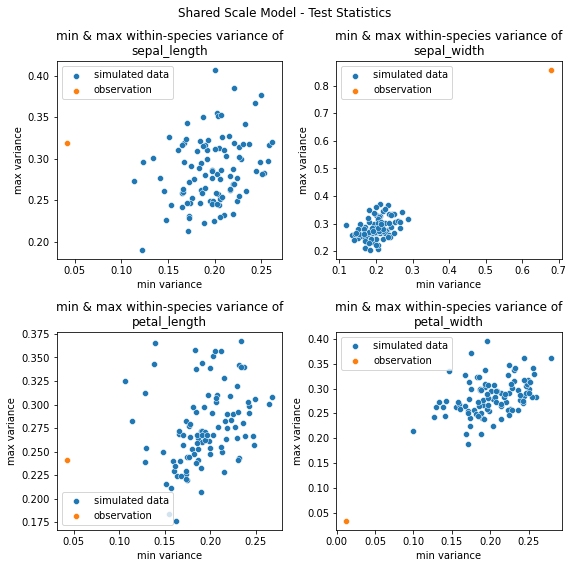

In [23]:
simulator = lambda: simulate_shared(X)
plot_check(X, df.label, simulator, features, "Shared Scale Model")

In [ ]:
simulator = lambda: simulate_pooled(X)
plot_check(X, df.label, simulator, features, "Shared Scale Model")

/home/noamsgl/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/noamsgl/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/noamsgl/.local/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/noamsgl/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3723: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/noamsgl/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/noamsg

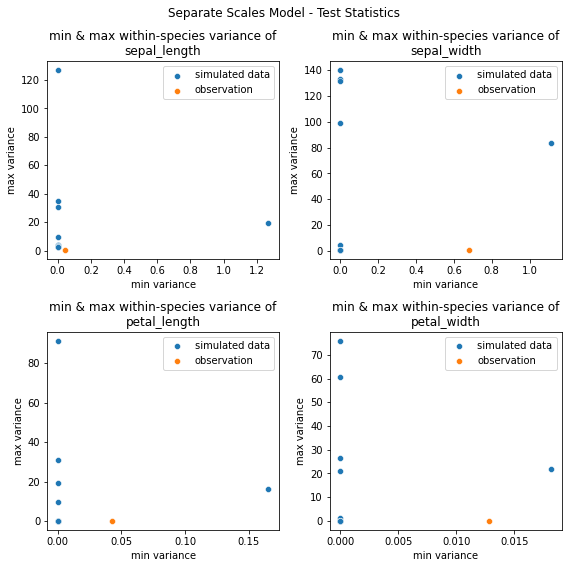

In [24]:
simulator = lambda: simulate_separate(X)
simulations = plot_check(X, df.label, simulator, features, "Separate Scales Model")
# todo: fix runtime warnings

## Evaluating the Models

In [54]:
def loocv(sampler, X, Y, compute_lpd):
    lpd = 0.
    for i in tqdm(range(len(X))):
        print(f"Beginning Sample {i} of {len(X)}")
        subdata = torch.vstack((X[:i], X[i+1:]))
        chain = sampler(subdata).get_samples()
        lpd += compute_lpd(chain, X[i], Y)
    return lpd

In [55]:
def lpd_shared_scale(chain, X, Y):
    lpd = 0.
    B = len(X)  # number of data points (batch size)
    D = X.size(-1)  # dimension of each data point
    S = len(chain)  # number of mcmc samples
    for i in range(B):
        lpdi = 0.
        for j in range(S):
            weights = chain["weights"][j]
            assignment = np.random.choice(K, p=weights.numpy())
            locs = chain["locs"][j][assignment]
            scale = chain["scale"][j]
            lpdi += scipy.stats.multivariate_normal(locs, scale * np.eye(D)).logpdf(Y[i])
        lpdi /= S
        lpd += lpdi
    return lpd

In [69]:
def lpd_pooled_scale(chain, X, Y):
    lpd = 0.
    B = len(X)  # number of data points (batch size)
    D = X.size(-1)  # dimension of each data point
    S = len(chain)  # number of mcmc samples
    for i in range(B):
        lpdi = 0.
        for j in range(S):
            weights = chain["weights"][j]
            assignment = np.random.choice(K, p=weights.numpy())
            locs = chain["locs"][j][assignment]
            scale = chain["scale"][j][assignment]
            lpdi += scipy.stats.multivariate_normal(locs, scale * np.eye(D)).logpdf(Y[i])
        lpdi /= S
        lpd += lpdi
    return lpd

In [66]:
def lpd_separate_scales(chain, X, Y):
    lpd = 0.
    B = len(X)  # number of data points (batch size)
    D = X.size(-1)  # dimension of each data point
    S = len(chain)  # number of mcmc samples
    for i in range(B):
        lpdi = 0.
        for j in range(S):
            weights = chain["weights"][j]
            assignment = np.random.choice(K, p=weights.numpy())
            locs = chain["locs"][j][assignment]
            M = chain["matrix"][j][assignment]
            scales = torch.matmul(M, M.T)
            lpdi += scipy.stats.multivariate_normal(locs, scales).logpdf(Y[i])
        lpdi /= S
        lpd += lpdi
    return lpd

In [58]:
lpd_shared_scale = loocv(sample_shared, X, df.label, lpd_shared_scale)

100%|██████████| 150/150 [15:46:52<00:00, 378.75s/it]


In [70]:
lpd_pooled_scale = loocv(sample_pooled, X, df.label, lpd_pooled_scale)

NameError: name 'sample_pooled' is not defined

In [68]:
lpd_separate_scale = loocv(sample_separate, X, df.label, lpd_separate_scales)

100%|██████████| 150/150 [10:19:42<00:00, 247.88s/it]


In [60]:
lpd_shared_scale

-4097.4352225616685

In [72]:
lpd_separate_scale

-7378.073115165566

In [ ]:
def plot_posterior(X, mus=None, sigmas=None, fill=None, border=None):
    # Create figure
    fig = plt.figure()

    # Plot data
    sns.scatterplot(x=X[:,0], y=X[:,1], hue=fill, palette="deep").set(title="PCA 2d Projection of Data and Inferred Parameters", xlabel="PC0", ylabel="PC1")

    # Plot cluster centers
    x = [float(m[0]) for m in mus.data]
    y = [float(m[1]) for m in mus.data]
    plt.scatter(x, y, 99, c='red')

    # Plot ellipses for each cluster
    for sig_ix in range(K):
        ax = fig.gca()
        cov = sigmas[sig_ix] * np.eye(4)
        lam, v = np.linalg.eig(cov)
        lam = np.sqrt(lam)
        ell = Ellipse(xy=(x[sig_ix], y[sig_ix]),
                        width=lam[0]*4, height=lam[1]*4,
                        angle=np.rad2deg(np.arccos(v[0, 0])),
                        color='blue')
        ell.set_facecolor('none')
        ax.add_artist(ell)
    return fig


def visualize_shared_posterior():
    chain = chn_shared
    # todo: 1) sample scales, locs
    # todo: 2) calculate MAP values (somehow... ?)
    locs = chain["locs"].mean(dim=0)
    scale = chain["scale"].mean(dim=0)
    scales = scale.expand(K)
    # weights = chain["weights"].mean(dim=0)
    # todo: get the probability vector that a point p belongs to K=0, 1, 2?
    # plot_posterior(X, locs.data, scales.data, weights, df.label)
    plot_posterior(X, locs, scales, df.label, None)

visualize_posterior(samples)

In [ ]:
sns.displot(data=samples["locs"][:,0, 1].numpy());

# TODO Notes

1. organize intro with pictures and better text
2. Implement model_separate with vector outer product (ask David why it doesn't work)
3. Visualize posterior 
4. sensitivity analysis (1 h)
5. information criteria? (1 h)
6. Remove prints
7. Constrain label switching
8. Optional: compare with K=2, K=4



# How to visualize posterior
get chn_model
X: points
X border: None
X fill: df.label
mu/sigma: point/ellipse
